# Home Credit Data - Fairness Assessment

In [106]:
# Step 1: Import Required Libraries

# data manipulation libraries
import pandas as pd
import numpy as np
from time import time
from IPython.display import display, Markdown, Latex
from typing import List, Union, Dict

# Graphs libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

# AIF Libraries
from aif360.datasets import StandardDataset,BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification
from aif360.explainers import MetricTextExplainer
from aif360.algorithms.preprocessing import Reweighing 

# Machine Learning libraries
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc,roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler

import warnings
sns.set()
sns.set_context("talk")

In [107]:
# Step 2: Import Data - Given Data
# Training data
train = pd.read_csv('C:/Users/Desktop/Megha Nanda/application_train.csv')

In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [109]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
#See the distribution of Defaulters and Non Defaulters
datax = train['TARGET'].value_counts().sort_index()
datax

0    282686
1     24825
Name: TARGET, dtype: int64

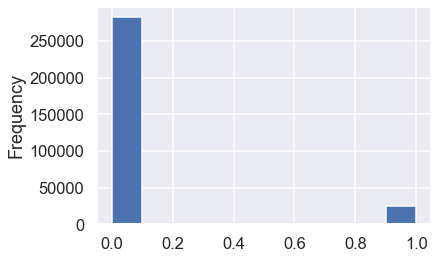

In [111]:
#Plot the default distribution
train['TARGET'].astype(int).plot.hist();

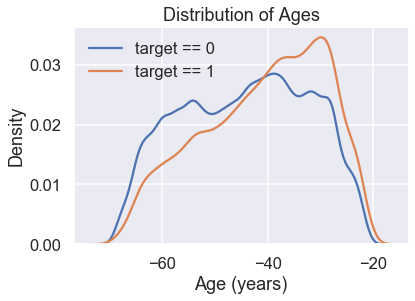

In [112]:
# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [119]:
# Function to calculate missing values by column
def missing_values_func(df):
        # Overall missing values
        mis_val_all = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percentage = 100 * df.isnull().sum() / len(df)
        
        # Create a table with the results
        mis_val_table = pd.concat([mis_val_all, mis_val_percentage], axis=1)
        
        mis_val_table_new_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing in descending order
        mis_val_table_new_columns = mis_val_table_new_columns[
            mis_val_table_new_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # summary information
        print ("The dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_new_columns.shape[0]) +
              " columns that has missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_new_columns

In [120]:
# Missing values statistics
missing_values = missing_values_func(train)
missing_values.head(50)

The dataframe has 122 columns.
There are 67 columns that has missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [10]:
# Remove column with more than 59% missing
train = train.drop(['COMMONAREA_MEDI','COMMONAREA_AVG','COMMONAREA_MODE','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAPARTMENTS_MODE'
                ,'NONLIVINGAPARTMENTS_AVG','FONDKAPREMONT_MODE','LIVINGAPARTMENTS_MODE','LIVINGAPARTMENTS_MEDI',
                'LIVINGAPARTMENTS_AVG','FLOORSMIN_MODE','FLOORSMIN_MEDI','YEARS_BUILD_AVG','OWN_CAR_AGE','LANDAREA_AVG'
                ,'LANDAREA_MEDI','LANDAREA_MODE','BASEMENTAREA_MEDI','BASEMENTAREA_AVG','BASEMENTAREA_MODE','NONLIVINGAREA_MEDI',
                'NONLIVINGAREA_MODE','NONLIVINGAREA_AVG','ELEVATORS_MEDI','ELEVATORS_MODE','ELEVATORS_AVG','WALLSMATERIAL_MODE',
                'APARTMENTS_MODE','APARTMENTS_MEDI','APARTMENTS_AVG','ENTRANCES_MODE','ENTRANCES_MEDI','ENTRANCES_AVG','LIVINGAREA_MEDI',
                'LIVINGAREA_MODE','LIVINGAREA_AVG','HOUSETYPE_MODE','FLOORSMAX_MEDI','FLOORSMAX_AVG','FLOORSMAX_MODE'], axis = 1)

In [11]:
a = ['XNA']
train = train[~train['CODE_GENDER'].isin(a)]

In [12]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
           
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [13]:
train['CODE_GENDER'].value_counts()

0    202448
1    105059
Name: CODE_GENDER, dtype: int64

In [14]:
#CORRELATIONS

# Find correlations with the target and sort
correlations = train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031295
DEF_30_CNT_SOCIAL_CIRCLE       0.032261
LIVE_CITY_NOT_WORK_CITY        0.032517
DAYS_REGISTRATION              0.041976
FLAG_DOCUMENT_3                0.044341
REG_CITY_NOT_LIVE_CITY         0.044394
FLAG_EMP_PHONE                 0.045984
REG_CITY_NOT_WORK_CITY         0.050992
DAYS_ID_PUBLISH                0.051457
CODE_GENDER                    0.054710
DAYS_LAST_PHONE_CHANGE         0.055219
REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060895
DAYS_BIRTH                     0.078242
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178926
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044934
AMT_GOODS_PRICE              -0.039647
REGION_POPULATION_RELATIVE   -0.037225
FLOORSMIN_AVG                -0.033619
TOTALAREA_MODE               -0.032599


# Balanced Data Analysis 

In [15]:
# Oversampled Data to ensure equal ratio of targets and non targets
### IMPORT DATA ###
data = pd.read_csv('C:/Users/Desktop/Megha Nanda/bal_data_all.csv')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(52), int64(54), object(16)
memory usage: 186.2+ MB


In [17]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,430535,0,Cash loans,F,Y,N,1,90000.0,402939.0,21987.0,...,0,0,0,0,0,0,0,0,0,8
1,259454,0,Cash loans,F,Y,Y,0,117000.0,225000.0,24003.0,...,0,0,0,0,0,0,0,0,0,0
2,186241,0,Cash loans,F,Y,N,1,157500.0,450000.0,24412.5,...,0,0,0,0,0,0,1,0,0,4
3,172248,0,Cash loans,F,Y,N,1,202806.0,2340000.0,59152.5,...,0,0,0,0,0,0,0,0,0,0
4,315565,0,Cash loans,M,Y,Y,0,247500.0,1105083.0,39825.0,...,0,0,0,0,0,0,0,0,0,2


In [18]:
# Filter Columns finalised post lot of iterations and business understanding
data = data[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
                         'AMT_ANNUITY','DAYS_LAST_PHONE_CHANGE','DAYS_EMPLOYED','DAYS_BIRTH',
                         'DAYS_ID_PUBLISH','AMT_CREDIT','REGION_POPULATION_RELATIVE','AMT_GOODS_PRICE',
                        'HOUR_APPR_PROCESS_START','CODE_GENDER','TARGET','NAME_CONTRACT_TYPE']]


In [19]:
data.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_ID_PUBLISH,AMT_CREDIT,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,CODE_GENDER,TARGET,NAME_CONTRACT_TYPE
0,0.454901,0.551719,0.490258,21987.0,-1481,-1814,-12935,-5297,402939.0,0.022625,306000.0,12,F,0,Cash loans
1,0.505567,0.509710,0.740799,24003.0,-656,-2264,-14710,-5188,225000.0,0.007020,225000.0,13,F,0,Cash loans
2,0.425417,0.520808,0.228883,24412.5,-2221,-113,-12118,-516,450000.0,0.025164,450000.0,15,F,0,Cash loans
3,0.664468,0.313000,0.513694,59152.5,-6,-1469,-8918,-951,2340000.0,0.011657,2340000.0,18,F,0,Cash loans
4,0.395021,0.662655,0.317032,39825.0,-1424,-457,-12470,-3914,1105083.0,0.006207,904500.0,15,M,0,Cash loans


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   EXT_SOURCE_1                200000 non-null  float64
 1   EXT_SOURCE_2                200000 non-null  float64
 2   EXT_SOURCE_3                200000 non-null  float64
 3   AMT_ANNUITY                 200000 non-null  float64
 4   DAYS_LAST_PHONE_CHANGE      200000 non-null  int64  
 5   DAYS_EMPLOYED               200000 non-null  int64  
 6   DAYS_BIRTH                  200000 non-null  int64  
 7   DAYS_ID_PUBLISH             200000 non-null  int64  
 8   AMT_CREDIT                  200000 non-null  float64
 9   REGION_POPULATION_RELATIVE  200000 non-null  float64
 10  AMT_GOODS_PRICE             200000 non-null  float64
 11  HOUR_APPR_PROCESS_START     200000 non-null  int64  
 12  CODE_GENDER                 200000 non-null  object 
 13  TARGET        

In [21]:
datax = data['TARGET'].value_counts().sort_index()
datax

0     99651
1    100349
Name: TARGET, dtype: int64

The balanced data now shows 50% of target and non target population

In [22]:
# Drop selected column
cols_to_drop = ['HOUR_APPR_PROCESS_START']
data.drop(columns=cols_to_drop, inplace=True)
cols_to_drop = []

In [23]:
data.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_ID_PUBLISH,AMT_CREDIT,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,CODE_GENDER,TARGET,NAME_CONTRACT_TYPE
0,0.454901,0.551719,0.490258,21987.0,-1481,-1814,-12935,-5297,402939.0,0.022625,306000.0,F,0,Cash loans
1,0.505567,0.509710,0.740799,24003.0,-656,-2264,-14710,-5188,225000.0,0.007020,225000.0,F,0,Cash loans
2,0.425417,0.520808,0.228883,24412.5,-2221,-113,-12118,-516,450000.0,0.025164,450000.0,F,0,Cash loans
3,0.664468,0.313000,0.513694,59152.5,-6,-1469,-8918,-951,2340000.0,0.011657,2340000.0,F,0,Cash loans
4,0.395021,0.662655,0.317032,39825.0,-1424,-457,-12470,-3914,1105083.0,0.006207,904500.0,M,0,Cash loans


In [24]:
data.dtypes

EXT_SOURCE_1                  float64
EXT_SOURCE_2                  float64
EXT_SOURCE_3                  float64
AMT_ANNUITY                   float64
DAYS_LAST_PHONE_CHANGE          int64
DAYS_EMPLOYED                   int64
DAYS_BIRTH                      int64
DAYS_ID_PUBLISH                 int64
AMT_CREDIT                    float64
REGION_POPULATION_RELATIVE    float64
AMT_GOODS_PRICE               float64
CODE_GENDER                    object
TARGET                          int64
NAME_CONTRACT_TYPE             object
dtype: object

In [25]:
Y_columns = ['TARGET']
cat_columns = []
num_columns = []

for col in data.columns.values:
    if col in Y_columns:
        continue
    elif data[col].dtypes == 'int64':
        num_columns += [col]
    elif data[col].dtypes == 'float64':
        num_columns += [col]
    else:
        cat_columns += [col]

In [122]:
#handle missing values
median_val = pd.Series()
for col in num_columns:
    if col not in cols_to_drop:
        median_val[col] = data[col].median()

In [27]:
median_val

EXT_SOURCE_1                       0.426891
EXT_SOURCE_2                       0.552265
EXT_SOURCE_3                       0.447179
AMT_ANNUITY                    29880.000000
DAYS_LAST_PHONE_CHANGE          -919.000000
DAYS_EMPLOYED                  -1317.000000
DAYS_BIRTH                    -13765.000000
DAYS_ID_PUBLISH                -3162.000000
AMT_CREDIT                    552555.000000
REGION_POPULATION_RELATIVE         0.020246
AMT_GOODS_PRICE               463500.000000
dtype: float64

In [28]:
def handle_missing_values(data, median_val):
    df = data.copy()
    for col in df:
        if col in median_val.index.values:
            df[col] = df[col].fillna(median_val[col])
        else:
            df[col] = df[col].fillna("Missing value")
    
    return df

In [29]:
data = handle_missing_values(data, median_val)

In [30]:
cat_columns

['CODE_GENDER', 'NAME_CONTRACT_TYPE']

In [31]:
#Put a value called 'Missing value' 
categorical_features = cat_columns
# categorical_features = categorical_features 
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]

del cat_columns

In [32]:
data['CODE_GENDER'].value_counts()

M    129069
F     70931
Name: CODE_GENDER, dtype: int64

In [33]:
data['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         184030
Revolving loans     15970
Name: NAME_CONTRACT_TYPE, dtype: int64

In [34]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
data_encoded = data.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le

In [35]:
data_encoded.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_ID_PUBLISH,AMT_CREDIT,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,CODE_GENDER,TARGET,NAME_CONTRACT_TYPE
0,0.454901,0.551719,0.490258,21987.0,-1481,-1814,-12935,-5297,402939.0,0.022625,306000.0,0,0,0
1,0.505567,0.509710,0.740799,24003.0,-656,-2264,-14710,-5188,225000.0,0.007020,225000.0,0,0,0
2,0.425417,0.520808,0.228883,24412.5,-2221,-113,-12118,-516,450000.0,0.025164,450000.0,0,0,0
3,0.664468,0.313000,0.513694,59152.5,-6,-1469,-8918,-951,2340000.0,0.011657,2340000.0,0,0,0
4,0.395021,0.662655,0.317032,39825.0,-1424,-457,-12470,-3914,1105083.0,0.006207,904500.0,1,0,0


In [36]:
data_encoded['CODE_GENDER'].value_counts()
#M: 1
#F: 0

1    129069
0     70931
Name: CODE_GENDER, dtype: int64

In [37]:
data_encoded['NAME_CONTRACT_TYPE'].value_counts()
#Cash Loans: 0
#Revolving Loans : 1 

0    184030
1     15970
Name: NAME_CONTRACT_TYPE, dtype: int64

In [38]:
# SCALE  NUMERIC COLUMNS
numerical_features = [c for c in data.columns.values if c not in categorical_features]

for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    data_encoded[feature] = mms.transform(val)
    encoders[feature] = mms
    
data_encoded = data_encoded.astype(float)

del num_columns

In [39]:
data_encoded.head()
#F=0, M=1
#Cash loans = 0, Revolving loans = 1

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_ID_PUBLISH,AMT_CREDIT,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,CODE_GENDER,TARGET,NAME_CONTRACT_TYPE
0,0.473170,0.645118,0.556196,0.088330,0.643390,0.035142,0.698036,0.191450,0.089373,0.309272,0.065169,0.0,0.0,0.0
1,0.528012,0.595961,0.840741,0.097383,0.842042,0.033959,0.595494,0.208092,0.044944,0.093190,0.044944,0.0,0.0,0.0
2,0.441257,0.608947,0.259348,0.099222,0.465206,0.039613,0.745234,0.921374,0.101124,0.344429,0.101124,0.0,0.0,0.0
3,0.700009,0.365781,0.582813,0.255229,0.998555,0.036049,0.930098,0.854962,0.573034,0.157398,0.573034,0.0,0.0,0.0
4,0.408356,0.774929,0.359460,0.168435,0.657115,0.038709,0.724899,0.402595,0.264690,0.081932,0.214607,1.0,0.0,0.0


In [40]:
def decode_dataset(data, encoders, numerical_features, categorical_features):
    df = data.copy()
    for feature in df.columns.values:
        if feature in numerical_features:
            df[feature] = encoders[feature].inverse_transform(np.array(df[feature]).reshape(-1, 1))
    for feature in categorical_features:
        df[feat] = encoders[feature].inverse_transform(df[feature].astype(int))
    return df

In [41]:
decode_dataset(data_encoded, encoders=encoders, numerical_features=numerical_features, categorical_features=categorical_features).head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_ID_PUBLISH,AMT_CREDIT,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,CODE_GENDER,TARGET,NAME_CONTRACT_TYPE
0,0.454901,0.551719,0.490258,21987.0,-1481.0,-1814.0,-12935.0,-5297.0,402939.0,0.022625,306000.0,F,0.0,Cash loans
1,0.505567,0.509710,0.740799,24003.0,-656.0,-2264.0,-14710.0,-5188.0,225000.0,0.007020,225000.0,F,0.0,Cash loans
2,0.425417,0.520808,0.228883,24412.5,-2221.0,-113.0,-12118.0,-516.0,450000.0,0.025164,450000.0,F,0.0,Cash loans
3,0.664468,0.313000,0.513694,59152.5,-6.0,-1469.0,-8918.0,-951.0,2340000.0,0.011657,2340000.0,F,0.0,Cash loans
4,0.395021,0.662655,0.317032,39825.0,-1424.0,-457.0,-12470.0,-3914.0,1105083.0,0.006207,904500.0,M,0.0,Cash loans


In [42]:
data_perp_sex = data_encoded.drop(['NAME_CONTRACT_TYPE'], axis=1)
data_perp_sex.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_ID_PUBLISH,AMT_CREDIT,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,CODE_GENDER,TARGET
0,0.473170,0.645118,0.556196,0.088330,0.643390,0.035142,0.698036,0.191450,0.089373,0.309272,0.065169,0.0,0.0
1,0.528012,0.595961,0.840741,0.097383,0.842042,0.033959,0.595494,0.208092,0.044944,0.093190,0.044944,0.0,0.0
2,0.441257,0.608947,0.259348,0.099222,0.465206,0.039613,0.745234,0.921374,0.101124,0.344429,0.101124,0.0,0.0
3,0.700009,0.365781,0.582813,0.255229,0.998555,0.036049,0.930098,0.854962,0.573034,0.157398,0.573034,0.0,0.0
4,0.408356,0.774929,0.359460,0.168435,0.657115,0.038709,0.724899,0.402595,0.264690,0.081932,0.214607,1.0,0.0


In [43]:
categorical_names

{'CODE_GENDER': array(['F', 'M'], dtype=object),
 'NAME_CONTRACT_TYPE': array(['Cash loans', 'Revolving loans'], dtype=object)}

In [50]:
# Define Male as priviledged group 
privileged_sex = np.where(categorical_names['CODE_GENDER'] == 'M')[0]

In [51]:
# Convert into standard dataset as mandatory for fairness
data_orig_sex = StandardDataset(data_perp_sex, 
                               label_name='TARGET', 
                               favorable_classes=[1], 
                               protected_attribute_names=['CODE_GENDER'], 
                               privileged_classes=[privileged_sex])

In [52]:
def meta_data(dataset):
    # print out some labels, names, etc.
    display(Markdown("#### Dataset shape"))
    print(dataset.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(dataset.favorable_label, dataset.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(dataset.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(dataset.privileged_protected_attributes, dataset.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(dataset.feature_names)

In [230]:
meta_data(data_orig_sex)

#### Dataset shape

(200000, 12)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['CODE_GENDER']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE', 'CODE_GENDER']


In [53]:
# SPLIT DATA INTO TRAINING AND TESTING DATASET
np.random.seed(42)
data_orig_sex_train, data_orig_sex_test = data_orig_sex.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("TARGET :",data_orig_sex_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("TARGET :",data_orig_sex_test.features.shape)

#### Train Dataset shape

TARGET : (140000, 12)


#### Test Dataset shape

TARGET : (60000, 12)


In [58]:
#Split the test dataset into features and labels
X_test_sex = data_orig_sex_test.features
y_test_sex = data_orig_sex_test.labels.ravel()

In [59]:
#Model performance definitions
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

# Bias Identification

In [63]:
# Explainers on original data
from aif360.explainers import MetricTextExplainer

privileged_groups = [{'CODE_GENDER': 1}] #1: Male ; 0=Female
unprivileged_groups = [{'CODE_GENDER': 0}]

#Convert the dataset into Binary Label Dataset format 
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        data_orig_sex_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.44345241714758926


In [64]:
from sklearn.pipeline import make_pipeline

#train logistic regression on original data
dataset = data_orig_sex_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### Accuracy of the model :

0.7326833333333334


#### F1 score of the model :

0.7377748712498978


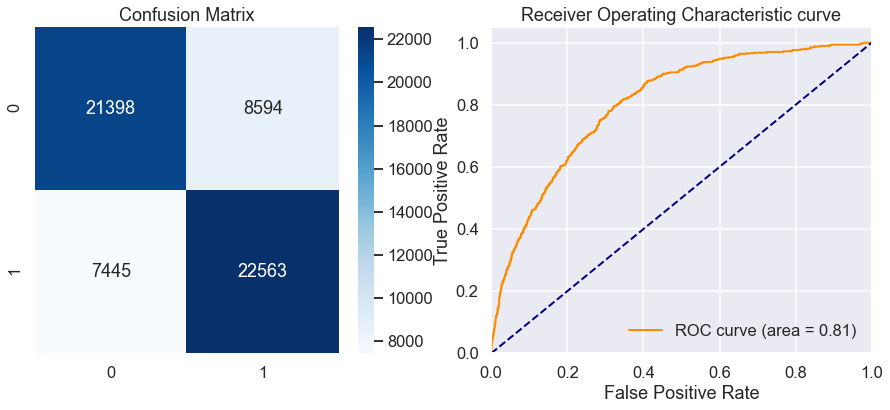

In [65]:
plot_model_performance(lr_orig_panel19, data_orig_sex_test.features, y_test_sex)

In [66]:
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier],
                       names: List[str],
                       scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names,
                         'importance': imp,
                         'std': var}).sort_values('importance',
                                                  ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

In [67]:
#Validate model on original data
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [68]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=data_orig_sex_test,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [87]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [88]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.4500
Best balanced accuracy: 0.7346
Corresponding 1-min(DI, 1/DI) value: 0.7368
Corresponding average odds difference value: -0.4551
Corresponding statistical parity difference value: -0.5721
Corresponding equal opportunity difference value: -0.4384
Corresponding Theil index value: 0.1475


 For all the fairness metrics displayed above, the value should be close to '0' for fairness.

 1-min(DI, 1/DI) < 0.2 is typically desired for classifier predictions to be fair.

 However, for a logistic regression classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

 Similarly, average odds difference=(FPRunpriv−FPRpriv)+(TPRunpriv−TPRpriv)/2 must be close to zero for the classifier to be fair.

 Again, the results for this classifier-data combination are still high. This still implies unfairness.

#### Accuracy of the model :

0.7326833333333334


#### F1 score of the model :

0.7377748712498978


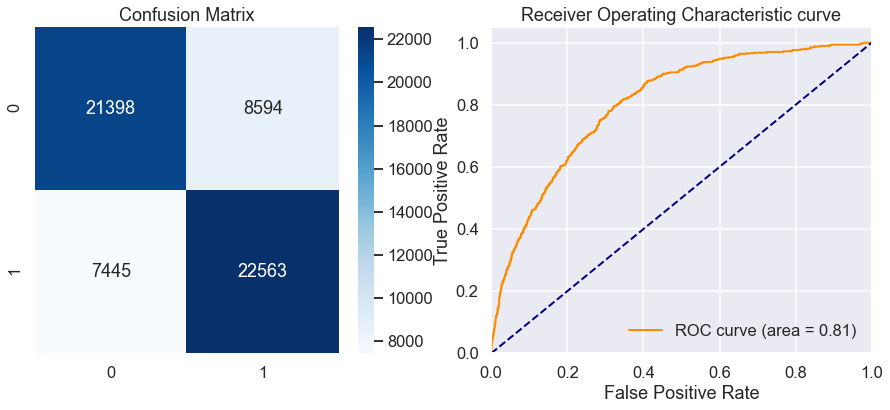

In [89]:
plot_model_performance(lr_orig_panel19, data_orig_sex_test.features, y_test_sex)

# Bias Mitigation

Pre Processing Algorithm- Reweighing

In [90]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_panel19_train = RW.fit_transform(data_orig_sex_train)

In [91]:
#Metrics for transformed data
metric_transf_panel19_train = BinaryLabelDatasetMetric(
        dataset_transf_panel19_train, #transformed data post reweighing
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_panel19_train = MetricTextExplainer(metric_transf_panel19_train)

print(explainer_transf_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999998


In [92]:
#Train LR model post reweighing
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [93]:
#Validating LR post reweighing
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=data_orig_sex_test,
                   model=lr_transf_panel19,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

In [94]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.5000
Best balanced accuracy: 0.6899
Corresponding 1-min(DI, 1/DI) value: 0.2233
Corresponding average odds difference value: 0.0263
Corresponding statistical parity difference value: -0.1200
Corresponding equal opportunity difference value: 0.0738
Corresponding Theil index value: 0.2175


The fairness metrics for the logistic regression model learned after reweighing are well improved, and thus the model is much more fair relative to the logistic regression model learned from the original data.

In-Processing Algorithm: Prejudice Remover

In [95]:
#Train PR model
model = PrejudiceRemover(sensitive_attr="CODE_GENDER", eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = data_orig_sex_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_panel19 = model.fit(dataset)

In [96]:
dataset = data_orig_sex_test.copy()

In [97]:
#Validate PR Model
thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = data_orig_sex_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig_panel19,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [98]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

In [99]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.4300
Best balanced accuracy: 0.6366
Corresponding 1-min(DI, 1/DI) value: 0.1890
Corresponding average odds difference value: -0.0019
Corresponding statistical parity difference value: -0.1007
Corresponding equal opportunity difference value: 0.0127
Corresponding Theil index value: 0.2534


#Post Processing Algorithm: Calibrated Equalised Odds

In [100]:
# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = data_orig_sex_train.copy(deepcopy=True)
dataset_orig_valid_pred = data_orig_sex_test.copy(deepcopy=True)

dataset_new_valid_pred = data_orig_sex_test.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(data_orig_sex_train.features)
y_train = data_orig_sex_train.labels.ravel()
lmod = LogisticRegression()
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == data_orig_sex_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = scale_orig.transform(data_orig_sex_test.features)
y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    

In [101]:
#results before Post processing
cm_pred_train = ClassificationMetric(data_orig_sex_train, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(data_orig_sex_test, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
-0.2826887719591347
Difference in GFNR between unprivileged and privileged groups
0.2816697111612197


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.2833643278173373
Difference in GFNR between unprivileged and privileged groups
0.2798502182136882


In [102]:
#Perform odds equalizing post processing on scores
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm
cost_constraint = "fnr"
randseed = 12345679

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
cpp = cpp.fit(data_orig_sex_test, dataset_orig_valid_pred)

In [103]:
#Transform validation and test data using the post processing algorithm
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)

In [104]:
#Results after post-processing
cm_transf_valid = ClassificationMetric(data_orig_sex_test, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.3994638872052874
Difference in GFNR between unprivileged and privileged groups
0.2073356266003608
